In [5]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

In [6]:
df = pd.read_csv('train_data.csv', delimiter="\t", header=None)
df.columns = ['id', 'label3', 'label4', 'rating', 'sub']

# NLP
# 1. To lower case
# No need to do this, because lowercase: bool, default=True
# df['sub'] = df['sub'].str.lower()

# 2. Replace useless signs
# The default regexp select tokens of 2 or more alphanumeric characters 
# (punctuation is completely ignored and always treated as a token separator).
df['sub'] = df['sub'].str.replace(r'[\d_.,:()?!;$#*"\'\[\]\\]+', '', regex=True)

# 3. Strip spaces
# df['sub'] = df['sub'].str.replace(r'[\s]+', ' ', regex=True)
# df['sub'] = df['sub'].str.strip()

# 4. Count the number of words in review
df['words'] = [len(x.split()) for x in df['sub'].tolist()]

# 5. Replace review mark with custom classes (eg good and bad)
df['rating'] = df['rating'].apply(lambda x: 'good' if x > 0.5 else 'bad')


ALPHAS = [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
ETAS = [0, 0.1, 0.001, 10, 100]


# 1. Convert a collection of text documents to a matrix of token counts
# 2. Transform a count matrix to a normalized tf or tf-idf representation
count_vect = CountVectorizer(stop_words={'english'})
tfidf_transformer = TfidfTransformer()

K_folds = 4

for K in range(K_folds):
    pass

for ALPHA in ALPHAS:
    for ETA in ETAS:
        # Shuffle data to get independent results
        df = df.sample(frac=1).reset_index(drop=True)

        # Select train and test data
        train_data = df[:int(len(df) * 0.7)]
        test_data = df[int(len(df) * 0.7):]
        cross_validation_data = df[int(len(df) * 0.3):int(len(df) * 0.7)]

        X_train = train_data['sub']
        Y_train = train_data['rating']

        X_test = test_data['sub']
        Y_test = test_data['rating']

        X_cross_validation = cross_validation_data['sub']
        Y_cross_validation = cross_validation_data['rating']
        

        X_train_counts = count_vect.fit_transform(X_train)
        X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

        # words = count_vect.get_feature_names()

        clf = MultinomialNB().fit(X_train_tfidf, Y_train)
        clf_svm = SGDClassifier(loss='log', alpha=ALPHA, eta0=ETA)
        # https://scikit-learn.org/stable/modules/sgd.html
        # SGD is a optimization method, while Logistic Regression (LR) is a machine learning algorithm/model.


        text_clf = Pipeline([
            ('vect', count_vect), 
            ('tfidf', tfidf_transformer), 
            ('clf', clf), 
        ])
        text_clf_svm = Pipeline([
            ('vect', count_vect), 
            ('tfidf', tfidf_transformer), 
            ('clf-svm', clf_svm), 
        ])

        _ = text_clf_svm.fit(X_train, Y_train)

        predicted = text_clf.predict(X_test)
        predicted_svm = text_clf_svm.predict(X_test)

        # The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it
        print(cross_validate(text_clf_svm, X_cross_validation, Y_cross_validation, cv=3))

        # debugging
        # for a, b in zip(X_test, zip(predicted_svm, Y_test)):
        #     print(a, b, end="\n\n")


        print('alpha = {:5} eta0 = {:5} NB = {:20} SVM = {:20}'.format(ALPHA, ETA, np.mean(predicted == Y_test) * 100, np.mean(predicted_svm == Y_test) * 100))

{'fit_time': array([0.42200327, 0.54409361, 0.47377539]), 'score_time': array([0.17899966, 0.18400526, 0.18630815]), 'test_score': array([0.59431138, 0.59370315, 0.5952024 ])}
alpha =    10 eta0 =     0 NB =    61.15922718187875 SVM =    58.82744836775483
{'fit_time': array([0.43545151, 0.45763493, 0.45483136]), 'score_time': array([0.20203686, 0.25752378, 0.26691127]), 'test_score': array([0.58383234, 0.47976012, 0.56971514])}
alpha =    10 eta0 =   0.1 NB =    62.82478347768154 SVM =    51.89873417721519
{'fit_time': array([0.42172194, 0.43683219, 0.45066118]), 'score_time': array([0.18676376, 0.18100357, 0.18614292]), 'test_score': array([0.57634731, 0.42278861, 0.42428786])}
alpha =    10 eta0 = 0.001 NB =    61.49233844103931 SVM =    54.69686875416389
{'fit_time': array([0.42777491, 0.45589113, 0.43221641]), 'score_time': array([0.19188046, 0.21139693, 0.25118804]), 'test_score': array([0.60778443, 0.59670165, 0.5982009 ])}
alpha =    10 eta0 =    10 NB =    58.82744836775483 SVM

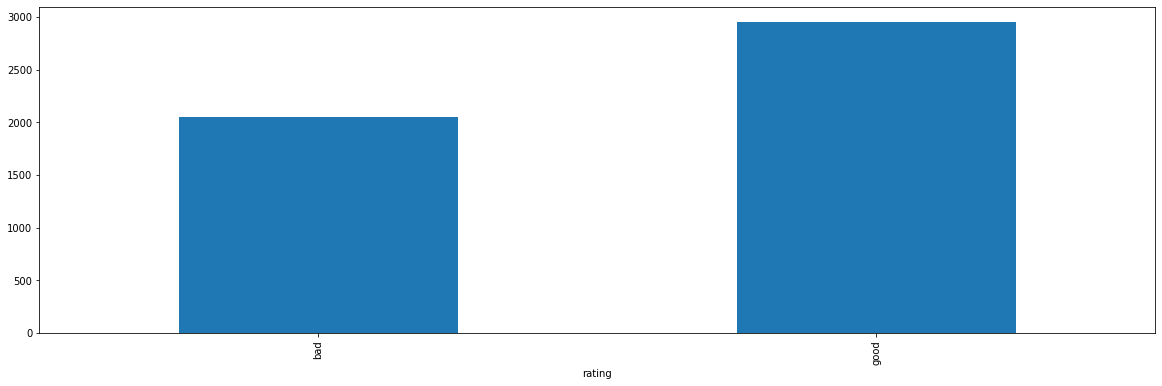

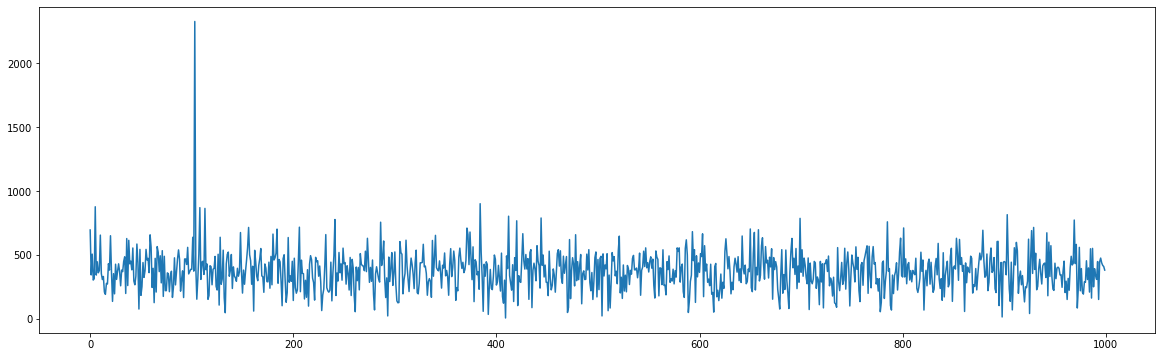

<AxesSubplot:>

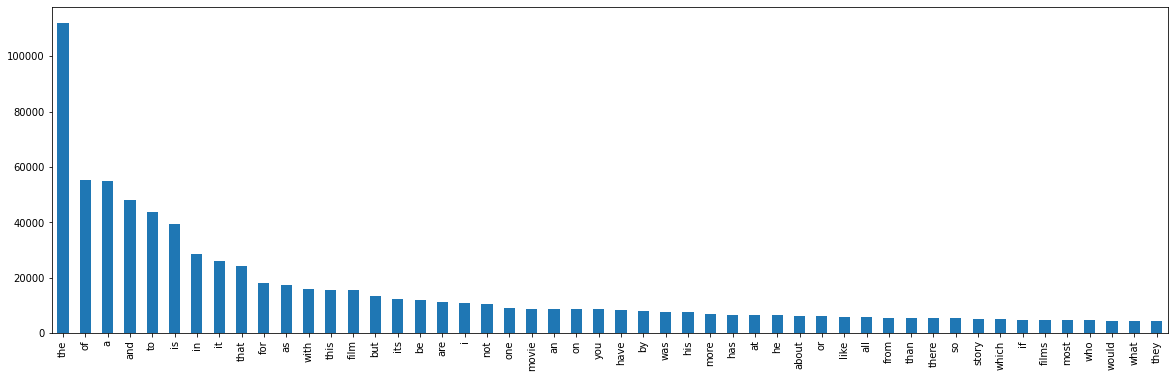

In [7]:
plt.figure(figsize=(20, 6))
df.groupby('rating').size().plot.bar(ylim=0)
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(list(range(1000)), df['words'][:1000])
plt.show()

freq = df['sub'].str.split(expand=True).stack().value_counts()

plt.figure(figsize=(20, 6))
freq[:50].plot(kind='bar')